In [17]:
import os
import torch
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
import numpy as np
from tqdm.notebook import tqdm
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

# from open3d.j_visualizer import JVisualizer

from alfred.dl.torch.common import device

ImportError: cannot import name 'JVisualizer' from 'open3d' (/home/nesc525/anaconda3/envs/3DSVC/lib/python3.8/site-packages/open3d/__init__.py)

In [2]:
import os
import armatures
from models import KinematicModel, KinematicPCAWrapper
import numpy as np
import config as config

%load_ext autoreload
%autoreload 2

np.random.seed(20160923)
pose_glb = np.zeros([1, 3]) # global rotation


########################## smpl settings ##########################
# note that in smpl and smpl-h no pca for pose is provided
# therefore in the model we fake an identity matrix as the pca coefficients
# to make the code compatible

n_pose = 23 * 3 # degrees of freedom, (n_joints - 1) * 3
# smpl 1.0.0: 10
# smpl 1.1.0: 300
n_shape = 10
# TODO: Read pose from skeleton
pose_pca = np.random.uniform(-0.2, 0.2, size=n_pose)
shape = np.random.normal(size=n_shape)
mesh = KinematicModel(os.path.join('../', config.SMPL_MODEL_1_0_PATH), armatures.SMPLArmature, scale=10)


In [11]:
def plot_pointcloud(mesh, title=""):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig)
    ax.scatter3D(x, z, y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.auto_scale_xyz(x, y)
    plt.show()

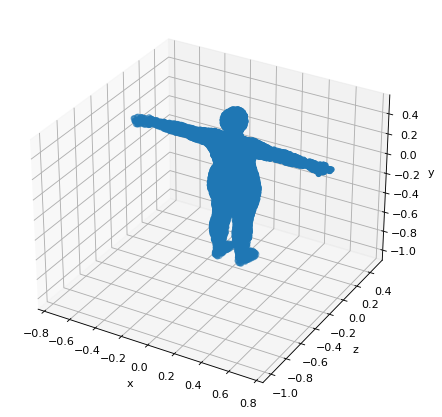

In [12]:
plot_pointcloud(mesh.mesh)

In [3]:
def get_derivative(model, params, n, eps):
    """
    Compute the derivative by adding and subtracting epsilon

    Parameters
    ----------
    model : object
      Model wrapper to be manipulated.
    params : np.ndarray
      Current model parameters.
    n : int
      The index of parameter.

    Returns
    -------
    np.ndarray
      Derivative with respect to the n-th parameter.
    """
    params1 = np.array(params)
    params2 = np.array(params)

    params1[n] += eps
    params2[n] -= eps

    res1 = model.run(params1)
    res2 = model.run(params2)

    d = (res1 - res2) / (2 * eps)

    return d.ravel()

  0%|          | 0/2000 [00:00<?, ?it/s]

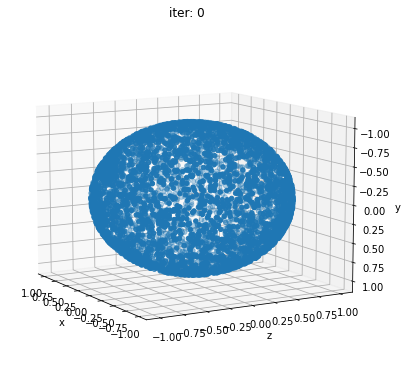

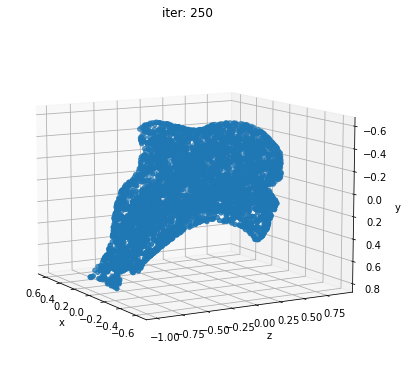

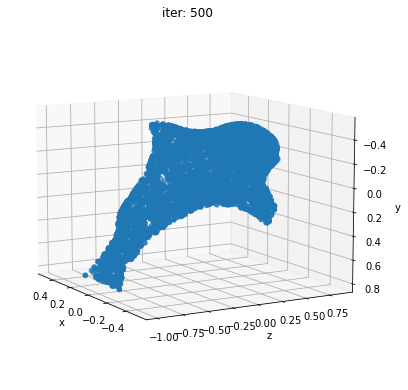

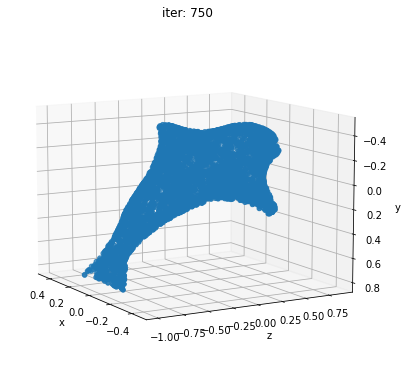

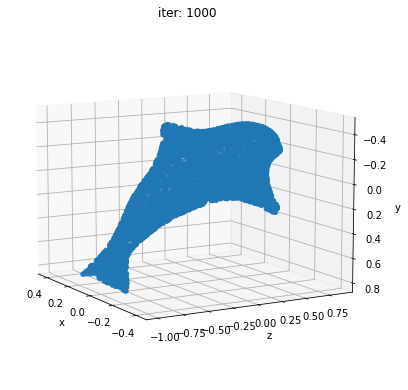

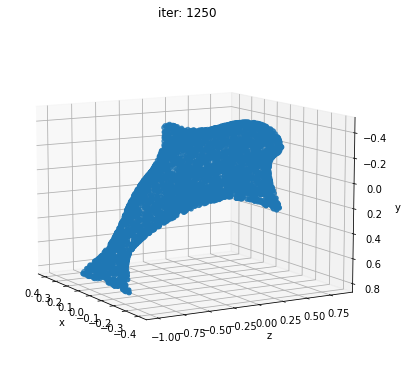

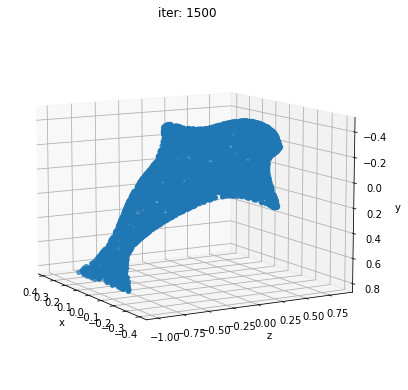

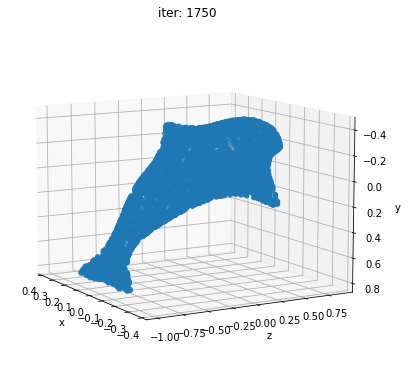

In [19]:
# Number of optimization steps
Niter = 2000
# Weight for the chamfer loss
w_chamfer = 1.0 
# Weight for mesh edge loss
w_edge = 1.0 
# Weight for mesh normal consistency
w_normal = 0.01 
# Weight for mesh laplacian smoothing
w_laplacian = 0.1 
# Wright for joints loss
w_joints = 1.0
# Plot period for the losses
plot_period = 250
loop = tqdm(range(Niter))

########################## solving example ############################

model = KinematicPCAWrapper(mesh, n_pose=n_pose)

mesh.set_params(pose_pca=pose_pca, pose_glb=pose_glb, shape=shape)
target_joints = mesh.get_joints().copy()
target_mesh = mesh.mesh.clone()

eps=1e-5
# max_iter=30
mse_threshold=1e-8

init = np.zeros(model.n_params)
out_n = np.shape(target_joints.flatten())[0]
jacobian = np.zeros([out_n, init.shape[0]])

params = init

chamfer_losses = []
laplacian_losses = []
edge_losses = []
normal_losses = []
joints_loss = []

%matplotlib inline

for i in loop:
    
    # Deform the mesh
    model.run(params)

    residual = (model.core.get_joints() - target_joints).reshape()

    joints_loss.append(np.mean(np.square(residual)))

    if i>0 and 
    
    # We sample 5k points from the surface of each mesh 
    sample_trg = sample_points_from_meshes(trg_mesh, 5000)
    sample_src = sample_points_from_meshes(new_src_mesh, 5000)
    
    # We compare the two sets of pointclouds by computing (a) the chamfer loss
    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)
    
    # and (b) the edge length of the predicted mesh
    loss_edge = mesh_edge_loss(new_src_mesh)
    
    # mesh normal consistency
    loss_normal = mesh_normal_consistency(new_src_mesh)
    
    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")
    
    # Weighted sum of the losses
    loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian
    
    # Print the losses
    loop.set_description('total_loss = %.6f' % loss)
    
    # Save the losses for plotting
    chamfer_losses.append(loss_chamfer)
    edge_losses.append(loss_edge)
    normal_losses.append(loss_normal)
    laplacian_losses.append(loss_laplacian)
    
    # Plot mesh
    if i % plot_period == 0:
        plot_pointcloud(new_src_mesh, title="iter: %d" % i)
        
    # Optimization step
    loss.backward()
    optimizer.step()

Text(0.5, 1.0, 'Loss vs iterations')

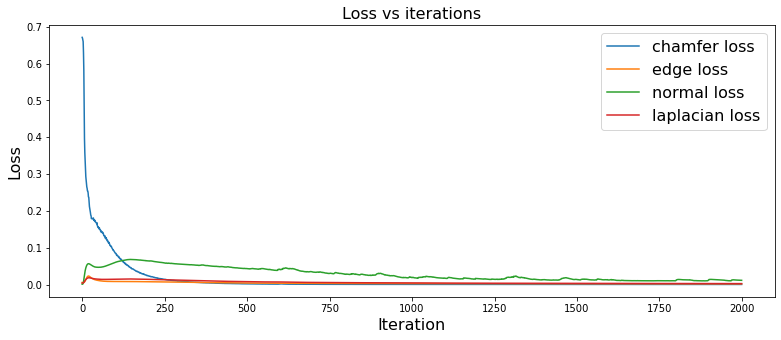

In [25]:
fig = plt.figure(figsize=(13, 5))
ax = fig.gca()
ax.plot(torch.tensor(chamfer_losses).cpu(), label="chamfer loss")
ax.plot(torch.tensor(edge_losses).cpu(), label="edge loss")
ax.plot(torch.tensor(normal_losses).cpu(), label="normal loss")
ax.plot(torch.tensor(laplacian_losses).cpu(), label="laplacian loss")
ax.legend(fontsize="16")
ax.set_xlabel("Iteration", fontsize="16")
ax.set_ylabel("Loss", fontsize="16")
ax.set_title("Loss vs iterations", fontsize="16")